In [24]:
"""This notebook provides exploratory visualisations into lateness and its composition"""
import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import lpad

In [2]:
spark = SparkSession.builder.appName("Bus Performance Data Mining").getOrCreate()


with open("config.yaml") as f:
    config = yaml.safe_load(f)
data_path = config["processed_path"] + "sample_50k.csv"

df = spark.read.csv(data_path, header=True, inferSchema=True)

25/07/10 01:09:04 WARN Utils: Your hostname, Hyle resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/07/10 01:09:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/10 01:09:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df.printSchema()

root
 |-- calendar_date: date (nullable = true)
 |-- timetable_time: timestamp (nullable = true)
 |-- route: string (nullable = true)
 |-- route_variant: string (nullable = true)
 |-- direction: string (nullable = true)
 |-- transit_stop: integer (nullable = true)
 |-- transit_stop_sequence: integer (nullable = true)
 |-- suburb: string (nullable = true)
 |-- depot: string (nullable = true)
 |-- bus_configuration: string (nullable = true)
 |-- seated_capacity: integer (nullable = true)
 |-- standing_capacity: integer (nullable = true)
 |-- total_capacity: integer (nullable = true)
 |-- capacity_bucket: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- timetable_hr_sin: double (nullable = true)
 |-- timetable_hr_cos: double (nullable = true)
 |-- timetable_min_sin: double (nullable = true)
 |-- timetable_min_cos: double (nullable = true)
 |-- day_of_week_sin: double (nullable = true)
 |-- day_of_week_cos: double (nullable = t

# Data Aggregation 

In [4]:
# Get total seconds since midnight
df = df.withColumn(
    "time_seconds",
    F.hour("timetable_time") * 3600 + F.minute("timetable_time") * 60 + F.second("timetable_time")
)

# 15-min bin index (0–95)
df = df.withColumn("time_bin", F.floor(F.col("time_seconds") / 900))

# Optional: human-readable bin label
df = df.withColumn(
    "bin_label",
    F.expr("lpad(floor(time_bin * 15 / 60), 2, '0') || ':' || lpad((time_bin * 15) % 60, 2, '0')")
)


agg_df = (
    df.groupBy("time_bin", "bin_label")
    .agg({"lateness_minutes": "avg"})
    .withColumnRenamed("avg(lateness_minutes)", "avg_lateness")
    .orderBy("time_bin")
)
agg_df.show()
pd_agg_df = agg_df.toPandas().sort_values("time_bin")

+--------+---------+--------------------+
|time_bin|bin_label|        avg_lateness|
+--------+---------+--------------------+
|       0|    00:00|   5.881578947368421|
|       1|    00:15|  0.6153846153846154|
|       2|    00:30|  0.8837209302325582|
|       3|    00:45|  1.9777777777777779|
|       4|    01:00|  3.7567567567567566|
|       5|    01:15|   6.361111111111111|
|       6|    01:30|  3.5172413793103448|
|       7|    01:45|   9.176470588235293|
|       8|    02:00|               2.875|
|       9|    02:15|  5.2592592592592595|
|      10|    02:30|  1.2083333333333333|
|      11|    02:45|  1.5217391304347827|
|      12|    03:00|-0.05555555555555555|
|      13|    03:15|                 5.2|
|      14|    03:30|  1.1304347826086956|
|      15|    03:45|                0.16|
|      16|    04:00| -0.9285714285714286|
|      17|    04:15|-0.26666666666666666|
|      18|    04:30|  0.3684210526315789|
|      19|    04:45|  0.4603174603174603|
+--------+---------+--------------

In [5]:
avg_lateness_by_suburb = (
    df.groupBy("suburb") \
    .agg(F.avg("lateness_minutes").alias("AVG_LATENESS")) \
    .orderBy("AVG_LATENESS", ascending=False)
)
avg_lateness_by_suburb.show(20)

+-------------+-----------------+
|       suburb|     AVG_LATENESS|
+-------------+-----------------+
|  spring hill|            18.25|
|   wongawilli|             16.0|
|   cliftleigh|             9.25|
|  castle cove|              8.3|
|horsfield bay|              8.0|
|      penrose|7.222222222222222|
|   barangaroo|              7.0|
|    edgecliff|              7.0|
|     sydenham|              7.0|
|  phillip bay|              7.0|
|   kirribilli|              7.0|
|  orangeville|              7.0|
| beaconsfield|6.071428571428571|
|    woodville|              6.0|
|        largs|              6.0|
|    watanobbi|5.923076923076923|
|     doyalson|             5.75|
|      birrong|5.666666666666667|
|dover heights|5.348484848484849|
|  middle cove|             5.05|
+-------------+-----------------+
only showing top 20 rows



In [6]:
avg_lateness_by_route = (
    df.groupBy("route") \
    .agg(F.avg("lateness_minutes").alias("AVG_LATENESS")) \
    .orderBy("AVG_LATENESS", ascending=False)
)
avg_lateness_by_route.show(20)

+-----+------------------+
|route|      AVG_LATENESS|
+-----+------------------+
| 6526|              31.0|
| 6263|              31.0|
| 584n|              29.0|
| 676e|              26.0|
| 2461|              25.0|
| 578n|              24.0|
| 697e|              24.0|
| 1378|23.333333333333332|
| 681e|              23.0|
| 713e|              23.0|
| 1621|              22.0|
| 6042|              19.0|
| 3590|              18.0|
| 613s|              17.5|
| 9057|              17.0|
| 6309|              17.0|
| 2077|              17.0|
| 674w|              17.0|
| 9055|             16.75|
|  x06|              16.6|
+-----+------------------+
only showing top 20 rows



In [7]:
bus_config_counts = (
    df
    .groupBy("bus_configuration", "lateness_bucket")
    .count()
    .orderBy("count", ascending=False)
)
bus_config_counts.show(10)

+-----------------+---------------+-----+
|bus_configuration|lateness_bucket|count|
+-----------------+---------------+-----+
|two door city bus|        On Time|13318|
|two door city bus|          Early|12191|
|two door city bus|   1–5 min Late|12092|
|two door city bus|  5–15 min Late| 4375|
|      hd standard|        On Time| 1252|
|      hd standard|   1–5 min Late| 1147|
|      hd standard|          Early| 1029|
|two door city bus| 15–30 min Late|  669|
|      articulated|          Early|  594|
|      articulated|   1–5 min Late|  564|
+-----------------+---------------+-----+
only showing top 10 rows



# Visualisation

In [8]:
# Casting time features to approppriate types 
pd_df = (
    df
    .withColumn("timetable_time", F.date_format("timetable_time", "yyyy-MM-dd HH:mm:ss"))
    .withColumn("calendar_date", F.date_format("calendar_date", "yyyy-MM-dd"))
    .dropna()
).toPandas()


# Cast datetime dtypes
pd_df["calendar_date"] = pd.to_datetime(pd_df["calendar_date"])
pd_df["timetable_time"] = pd.to_datetime(pd_df["timetable_time"])


# Add day name
pd_df["day"] = pd_df["calendar_date"].dt.day_name()
pd_df["hour_of_day"] = pd_df["timetable_time"].dt.hour + pd_df["timetable_time"].dt.minute / 60

25/07/10 01:09:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [9]:
pd_df.describe()

,calendar_date,timetable_time,transit_stop,transit_stop_sequence,seated_capacity,standing_capacity,total_capacity,is_weekend,timetable_hr_sin,timetable_hr_cos,timetable_min_sin,timetable_min_cos,day_of_week_sin,day_of_week_cos,lateness_minutes,time_seconds,time_bin,hour_of_day
count,50203,50203,5.020300e+04,50203.000000,50203.000000,50203.000000,50203.000000,50203.000000,50203.000000,50203.000000,50203.000000,50203.000000,50203.000000,50203.000000,50203.000000,50203.000000,50203.000000,50203.000000
mean,2016-10-21 08:34:03.989403136,2016-10-21 21:55:37.506124800,1.042771e+06,28.640898,47.781945,24.783260,72.565205,0.286198,-0.101696,-0.407540,-0.001604,-0.002933,-0.015233,-0.183795,1.724220,48093.516722,52.972571,13.359310
min,2016-08-08 00:00:00,2016-08-08 00:11:00,2.000200e+04,1.000000,25.000000,0.000000,32.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.974927,-0.900970,-60.000000,0.000000,0.000000,0.000000
25%,2016-08-11 00:00:00,2016-08-11 16:59:30,2.106290e+05,11.000000,44.000000,17.000000,62.000000,0.000000,-0.866024,-0.866024,-0.743143,-0.743143,-0.781834,-0.900968,-1.000000,32880.000000,36.000000,9.133333
50%,2016-11-22 00:00:00,2016-11-22 16:35:00,2.304740e+05,24.000000,47.000000,25.000000,71.000000,0.000000,-0.258816,-0.499998,0.000000,0.000001,0.000000,-0.222525,1.000000,49200.000000,54.000000,13.666667
75%,2016-11-26 00:00:00,2016-11-26 19:19:30,2.155217e+06,40.000000,50.000000,30.000000,80.000000,1.000000,0.707108,-0.000004,0.743144,0.669131,0.781831,0.623486,3.000000,61680.000000,68.000000,17.133333
max,2017-01-01 00:00:00,2017-01-01 23:58:00,2.782191e+06,168.000000,97.000000,63.000000,124.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.974928,1.000000,60.000000,86340.000000,95.000000,23.983333
std,NaN,NaN,1.011647e+06,22.282912,4.680276,9.873095,12.490453,0.451988,0.759458,0.496799,0.707645,0.706575,0.729965,0.658148,5.379297,16852.270458,18.724650,4.681186


# Visualisation

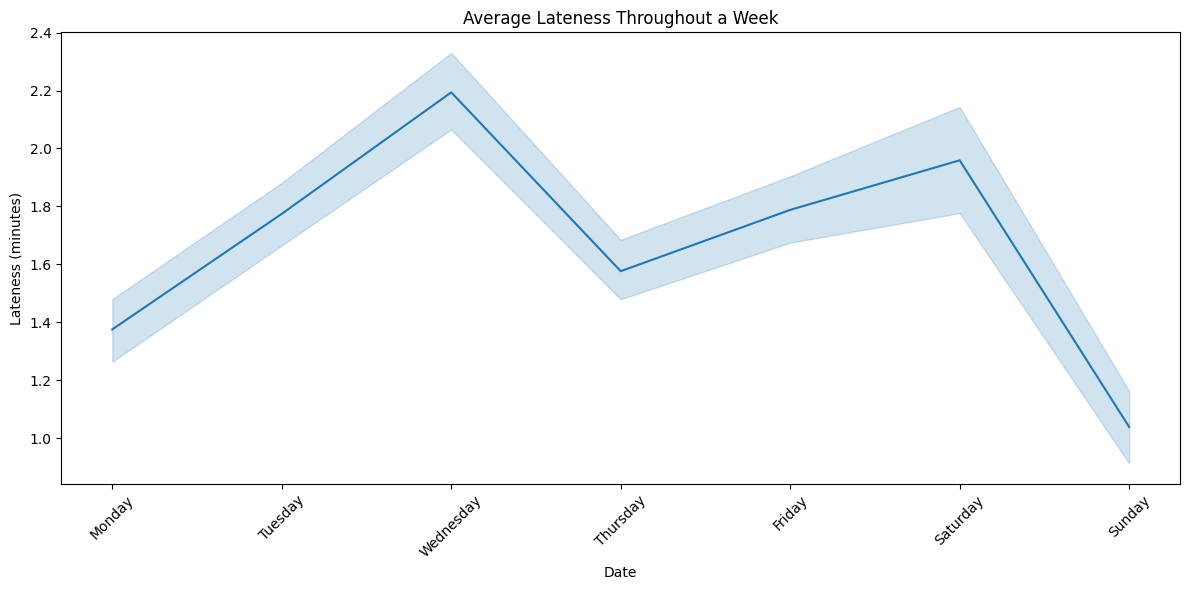

In [11]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=pd_df, x="day", y="lateness_minutes", estimator="mean")
plt.title("Average Lateness Throughout a Week")
plt.ylabel("Lateness (minutes)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

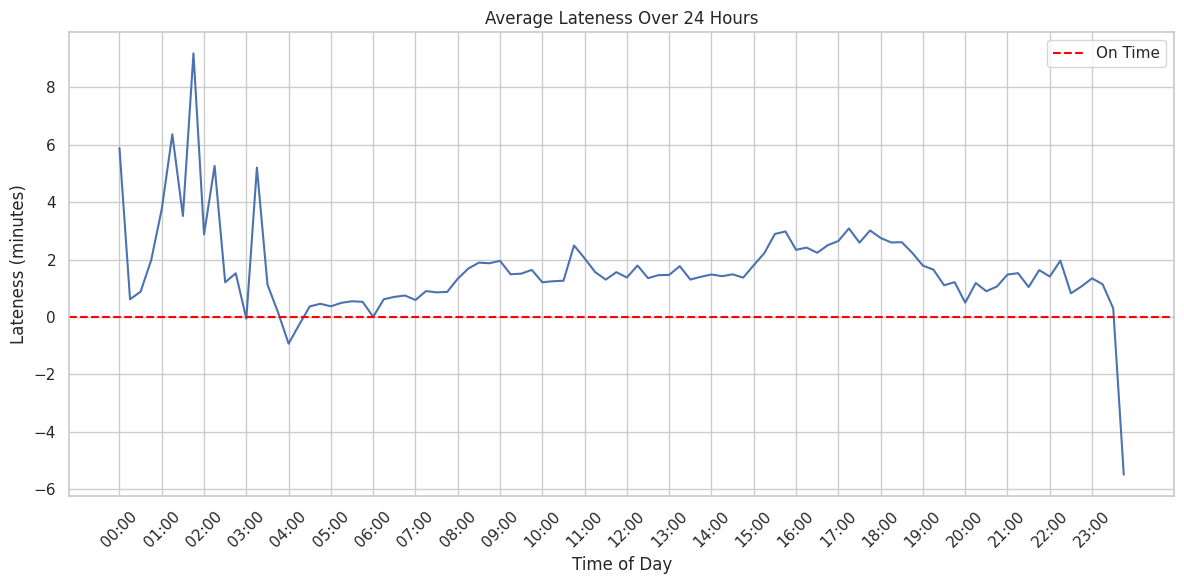

In [25]:
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=pd_agg_df, x="bin_label", y="avg_lateness", errorbar="sd")


# Show only every 4th label (1-hour gap)
step = 4
labels = pd_agg_df["bin_label"].unique()
ax.set_xticks(np.arange(0, len(labels), step))
ax.set_xticklabels(labels[::step], rotation=45)


plt.title("Average Lateness Over 24 Hours")
plt.ylabel("Lateness (minutes)")
plt.xlabel("Time of Day")
plt.axhline(0, color="red", linestyle="--", label="On Time")
plt.legend()
plt.tight_layout()
plt.show()

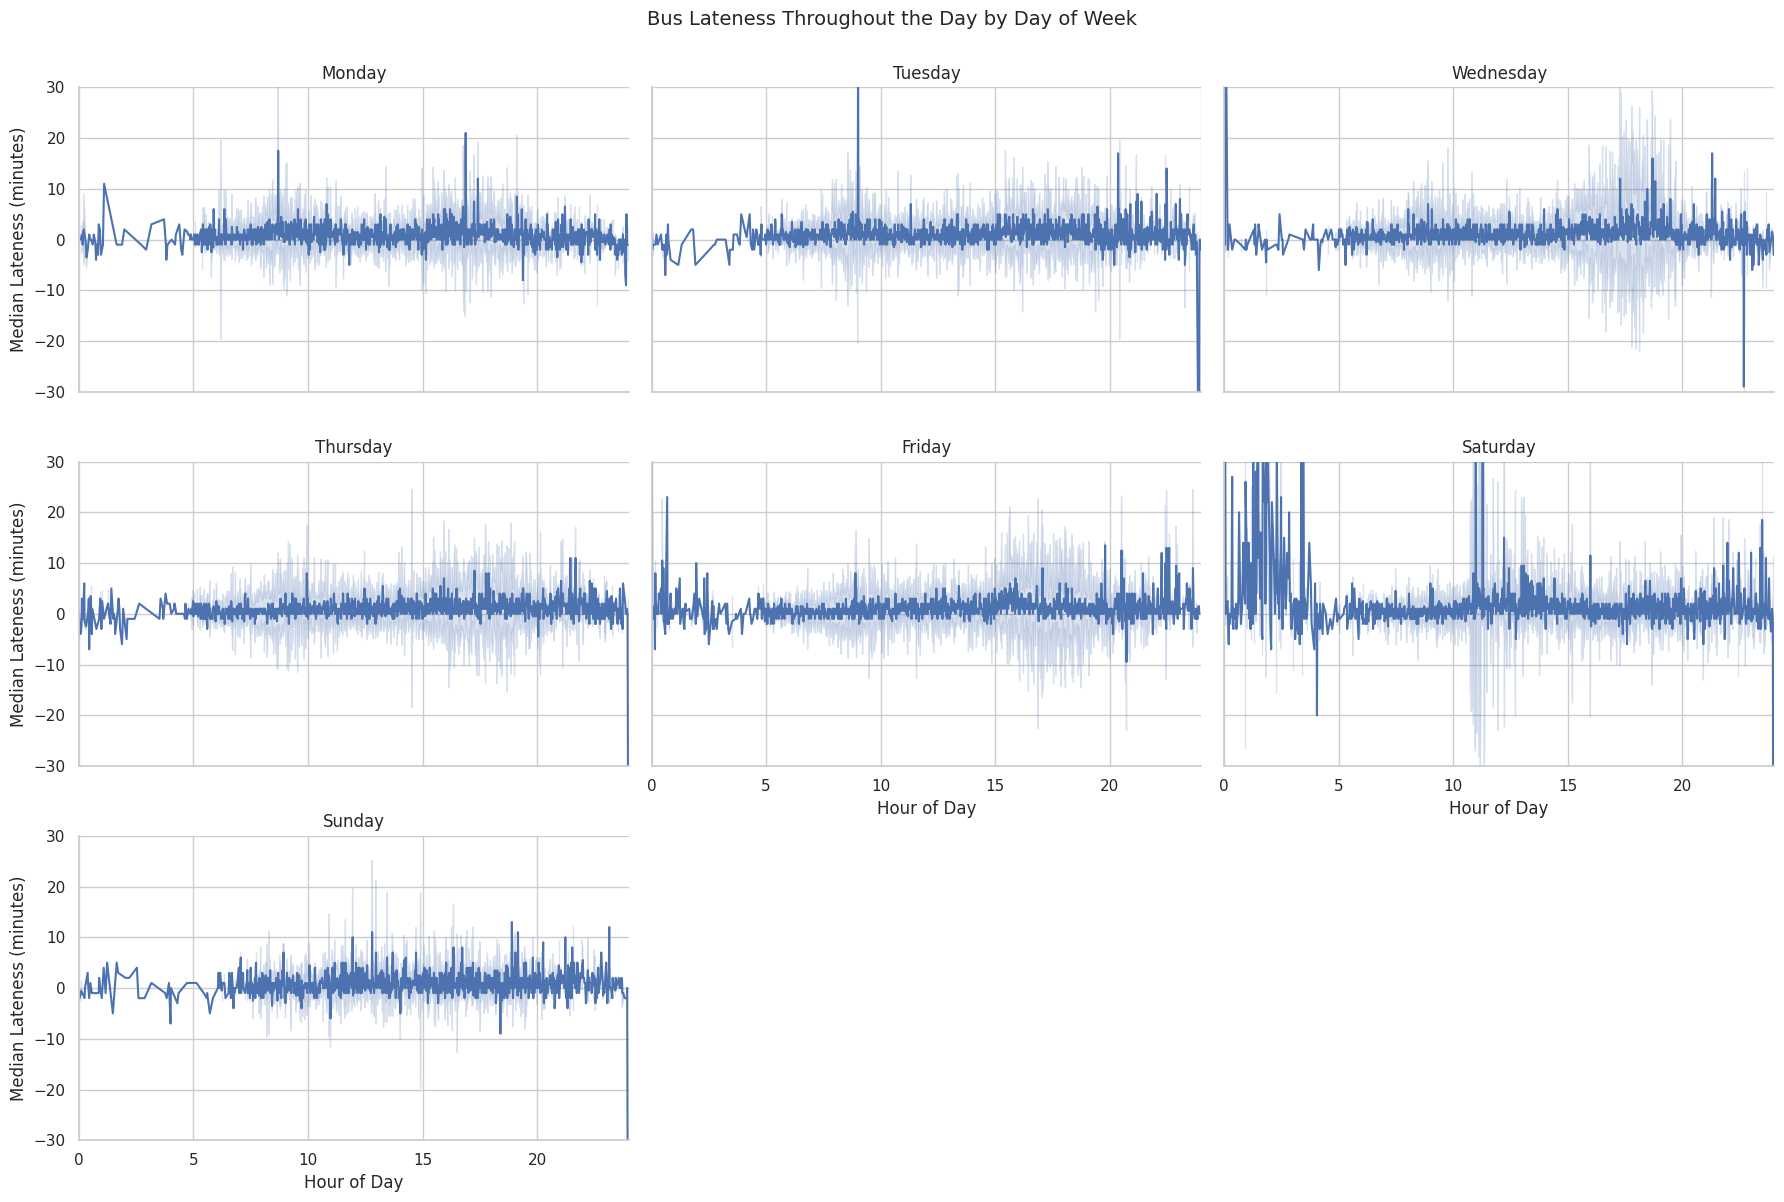

In [13]:
sns.set(style="whitegrid", rc={"figure.figsize": (18, 12)})
# Create the FacetGrid
g = sns.FacetGrid(
    pd_df, 
    col="day", 
    col_wrap=3, 
    height=4, 
    aspect=1.5
)

# Map lineplot to each facet
g.map_dataframe(
    sns.lineplot,
    x="hour_of_day",
    y="lateness_minutes",
    estimator="median",
    errorbar= "sd"
)
g.set(ylim=(-30, 30))
g.set(xlim=(0, 24))
# Set axis labels
g.set_axis_labels("Hour of Day", "Median Lateness (minutes)")
g.set_titles("{col_name}")
plt.suptitle("Bus Lateness Throughout the Day by Day of Week", fontsize=14, y=1.)
plt.tight_layout()
plt.show()

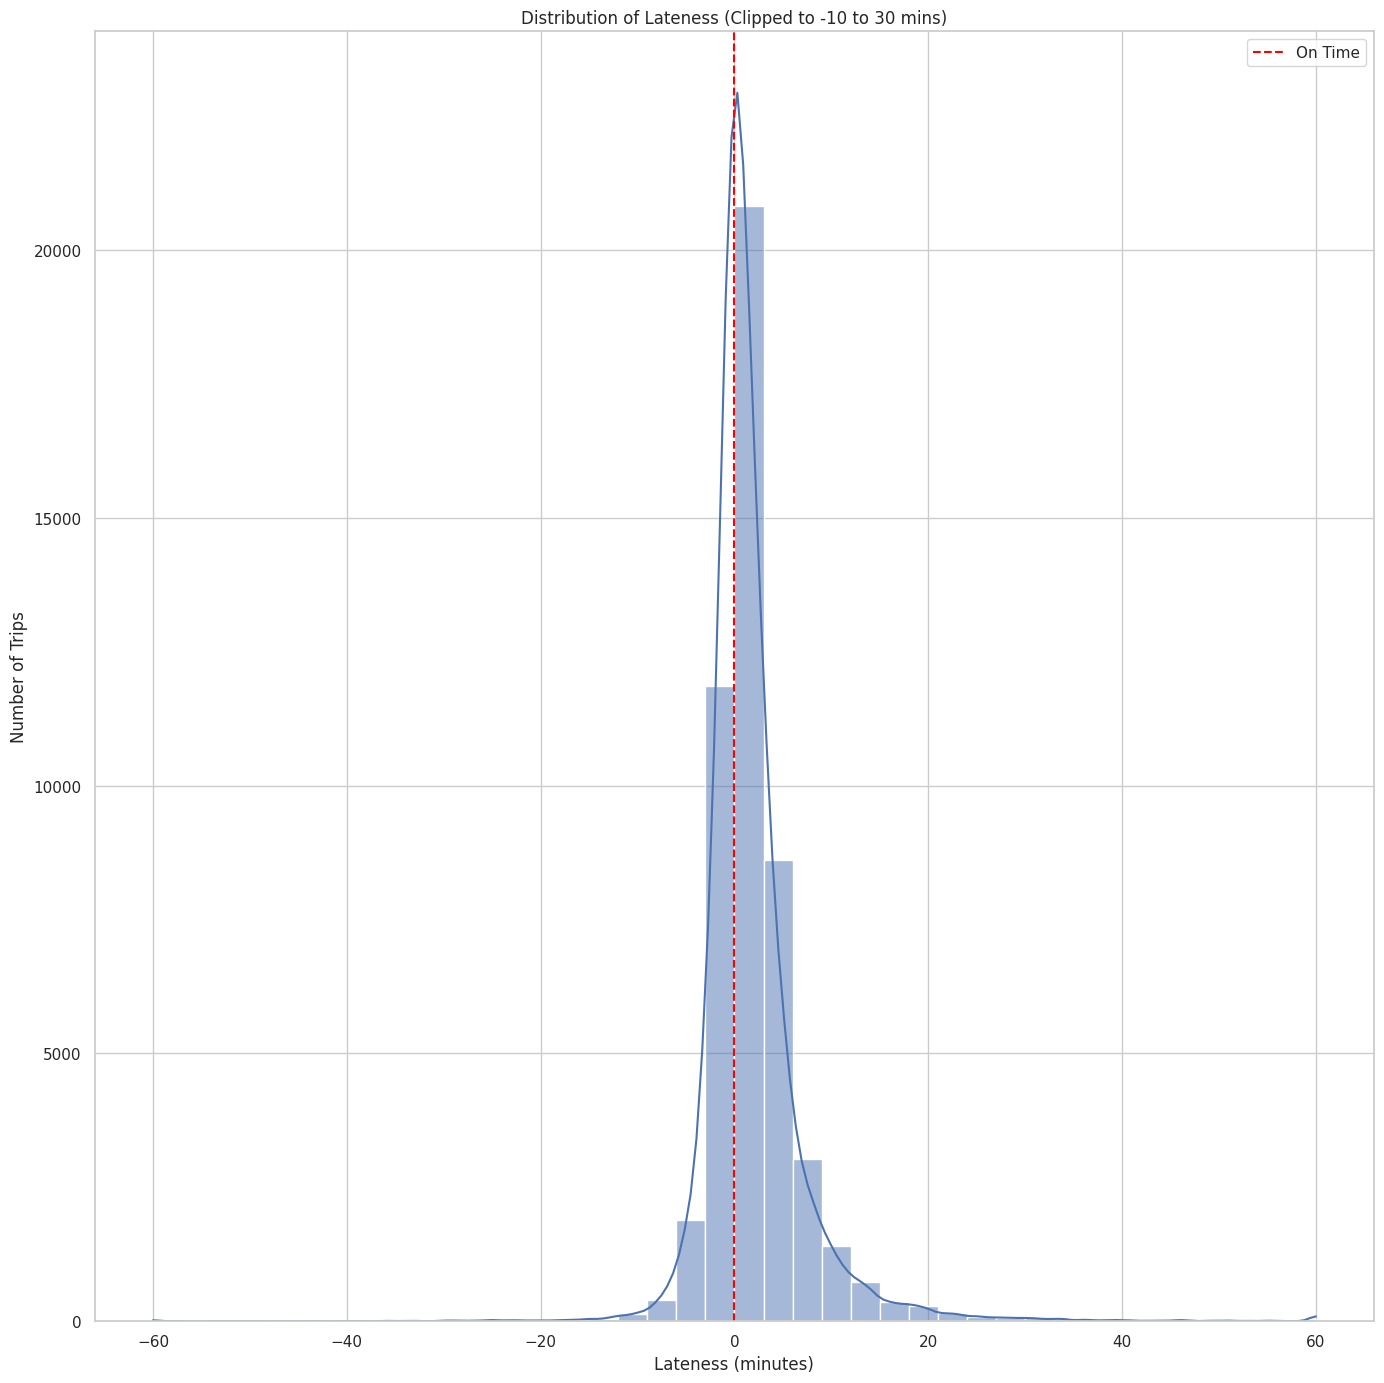

In [14]:
plt.figure(figsize=(14, 14))
sns.histplot(data=pd_df, x="lateness_minutes", bins=40, kde=True)
plt.title("Distribution of Lateness (Clipped to -10 to 30 mins)")
plt.axvline(0, color="red", linestyle="--", label="On Time")
plt.xlabel("Lateness (minutes)")
plt.ylabel("Number of Trips")
plt.legend()
plt.tight_layout()
plt.show()

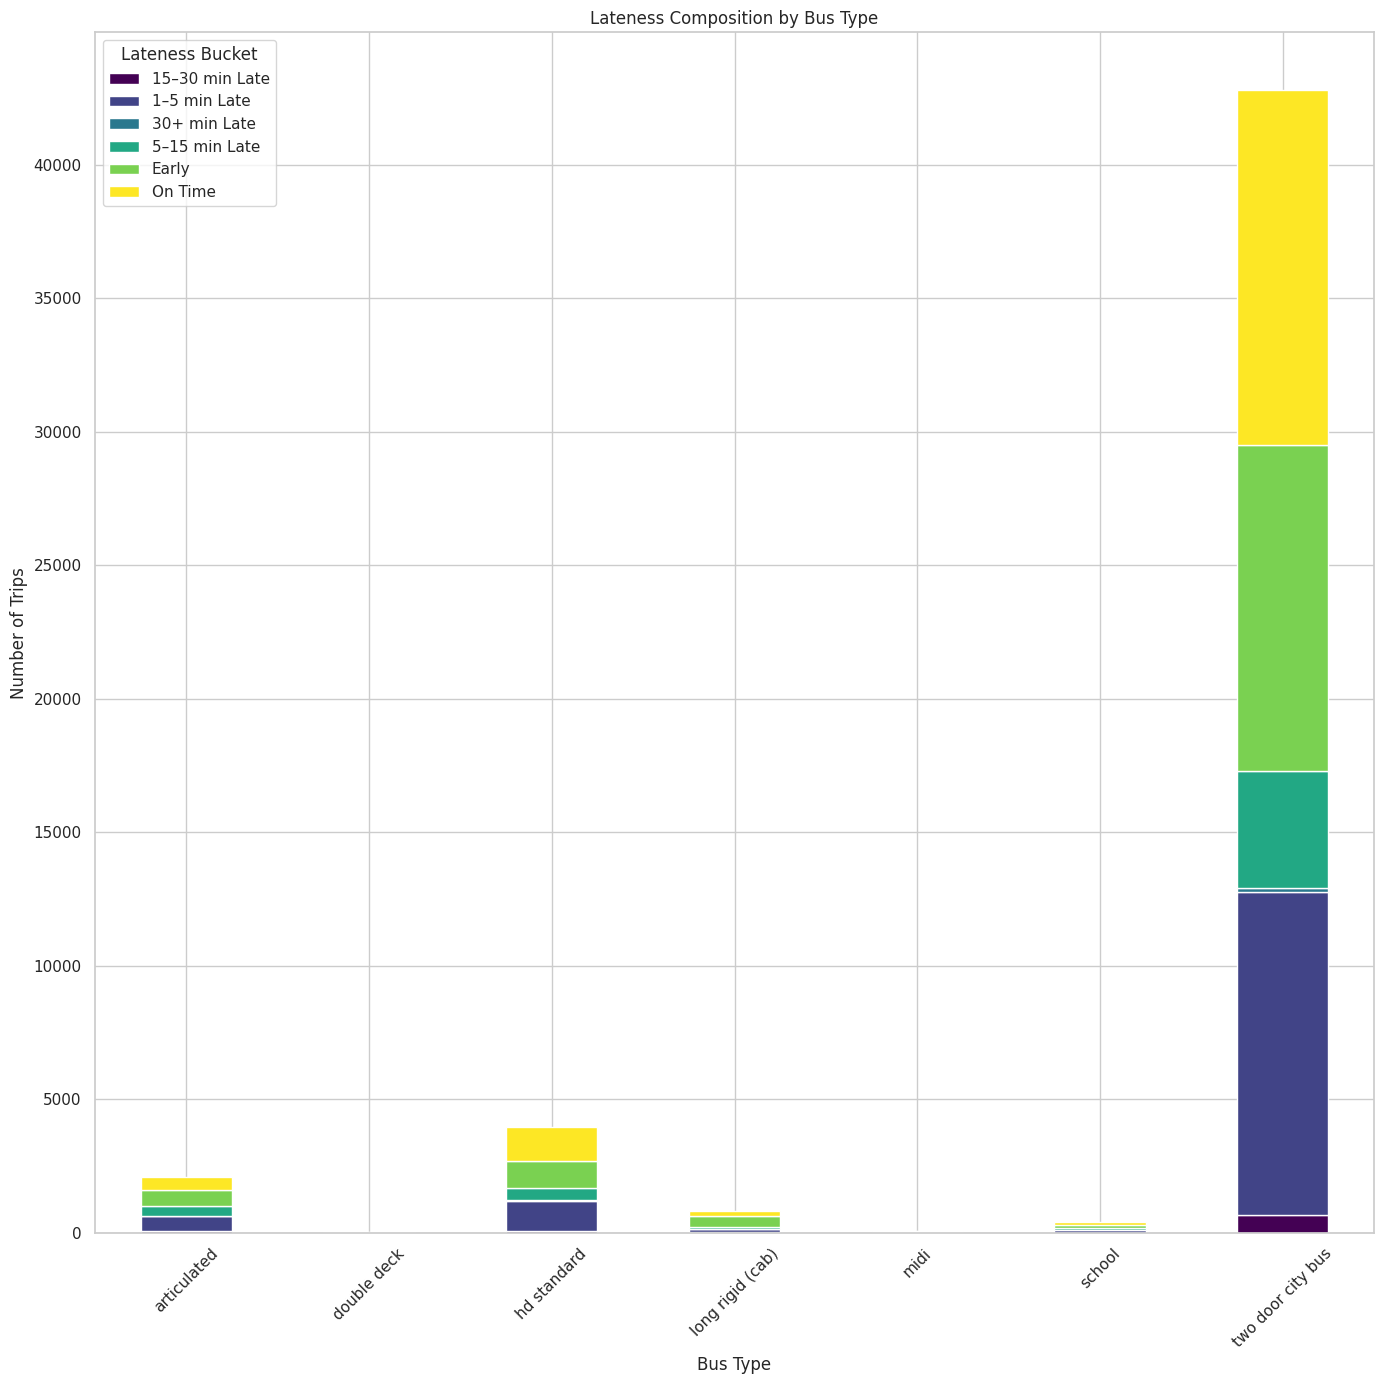

In [15]:
bus_configs_pd = bus_config_counts.toPandas()

pivot_df = bus_configs_pd.pivot(
    index="bus_configuration", 
    columns="lateness_bucket", 
    values="count"
)

pivot_df.plot(
    kind="bar", 
    stacked=True, 
    figsize=(14, 14), 
    colormap="viridis"
)

plt.title("Lateness Composition by Bus Type")
plt.xlabel("Bus Type")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.legend(title="Lateness Bucket")
plt.tight_layout()
plt.show()

<Axes: >

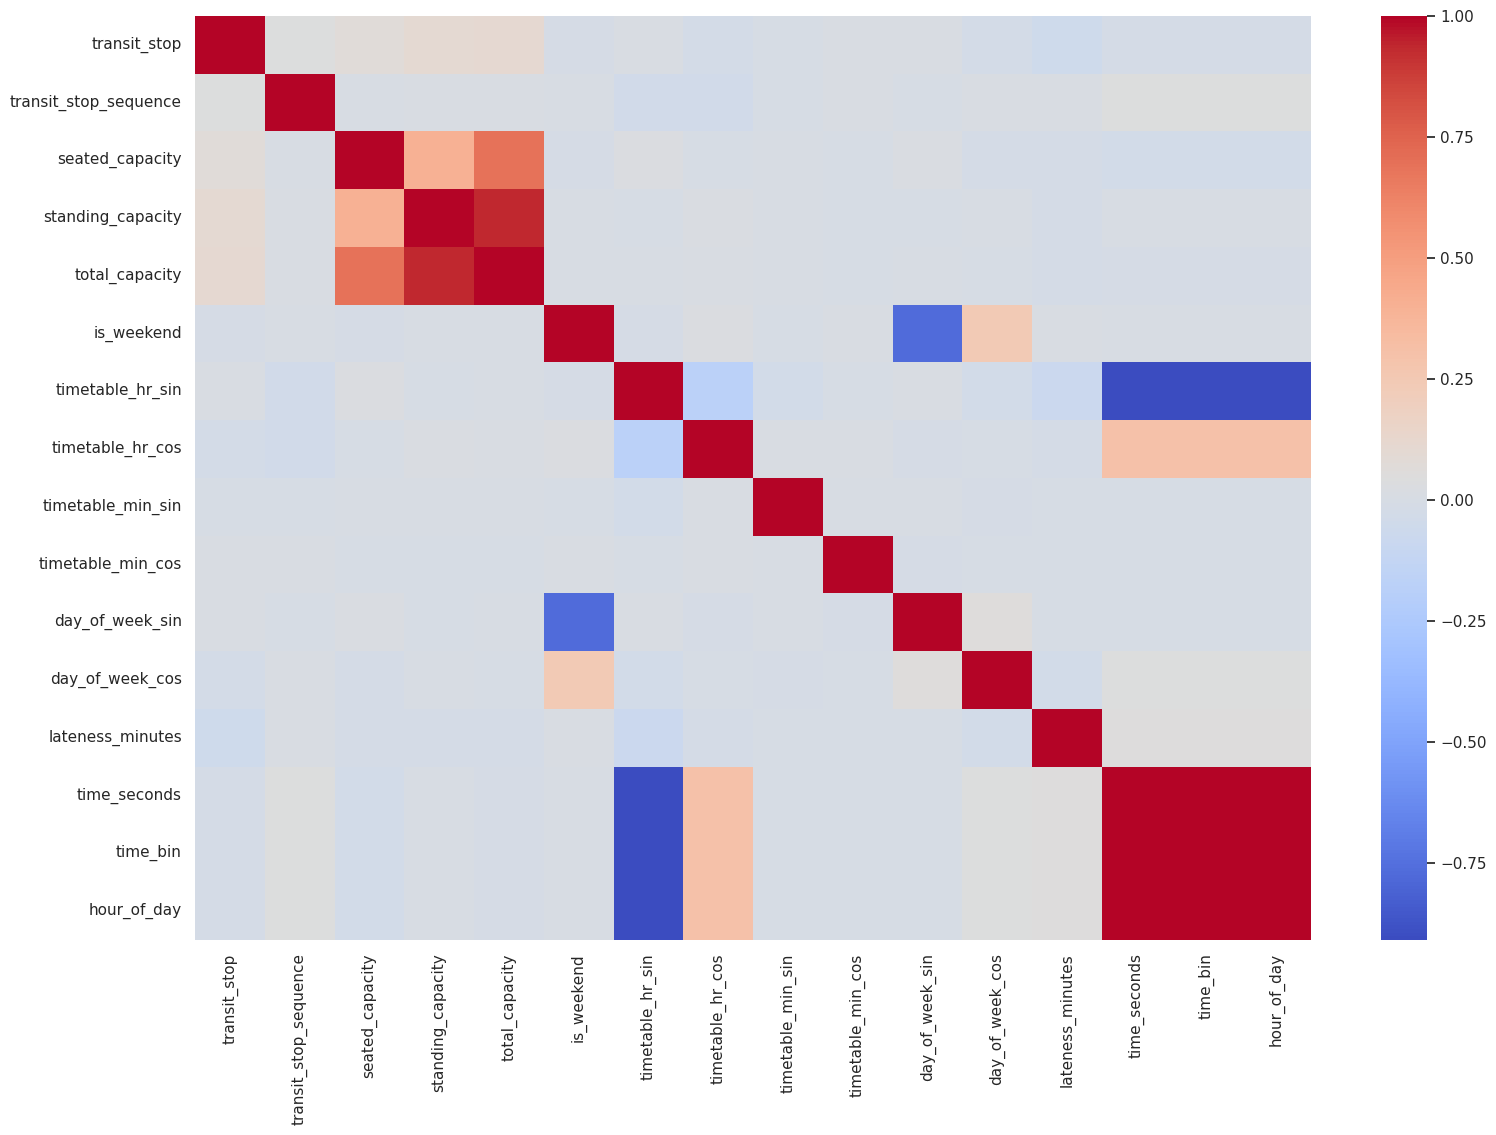

In [16]:
corr = pd_df.select_dtypes('number').corr()

# Plot the heatmap
sns.heatmap(corr, cmap='coolwarm')